In [1]:
import numpy as np
import os
import pandas as pd
import qiime2 as q2
import skbio
from classo import classo_problem
from qiime2.plugins import phylogeny
from skbio import TreeNode
from q2_ritme.process_data import load_n_split_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def create_matrix_from_tree(tree):
    # Get all leaves and create a mapping from leaf names to indices
    leaves = list(tree.tips())
    leaf_names = [leaf.name for leaf in leaves]
    # map each leaf name to unique index
    leaf_index_map = {name: idx for idx, name in enumerate(leaf_names)}

    # Get the number of leaves and internal nodes
    num_leaves = len(leaf_names)
    # root is not included
    internal_nodes = list(tree.non_tips())

    # Create the identity matrix for the leaves: A1 (num_leaves x num_leaves)
    A1 = np.eye(num_leaves)

    # Create the matrix for the internal nodes: A2 (num_leaves x
    # num_internal_nodes)
    # initialise it with zeros
    A2 = np.zeros((num_leaves, len(internal_nodes)))

    # Populate A2 with 1s for the leaves linked by each internal node
    # iterate over all internal nodes to find descendents of this node and mark
    # them accordingly
    a2_node_names = []
    for j, node in enumerate(internal_nodes):
        # todo: adjust names to consensus taxonomy from descentents
        # for now node names are just increasing integers - since node.name is float
        a2_node_names.append("n" + str(j))
        descendant_leaves = {leaf.name for leaf in node.tips()}
        for leaf_name in leaf_names:
            if leaf_name in descendant_leaves:
                A2[leaf_index_map[leaf_name], j] = 1

    # Concatenate A1 and A2 to create the final matrix A
    A = np.hstack((A1, A2))

    return A, a2_node_names

## Example data

In [3]:
# Create the tree nodes with lengths
n1 = TreeNode(name="n1")
f1 = TreeNode(name="f1", length=1.0)
f2 = TreeNode(name="f2", length=1.0)
n2 = TreeNode(name="n2")
f3 = TreeNode(name="f3", length=1.0)

# Build the tree structure with lengths
n1.extend([f1, f2])
n2.extend([n1, f3])
n1.length = 1.0
n2.length = 1.0

# n2 is the root of this tree
tree = n2
print(tree.ascii_art())

                    /-f1
          /n1------|
-n2------|          \-f2
         |
          \-f3


In [4]:
A_example, a2_names_ex = create_matrix_from_tree(tree)
A_example

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.]])

In [5]:
a2_names_ex

['n0']

## Real data: MA2

In [6]:
# read feature table
art_feature_table = q2.Artifact.load("data/220728_monthly/all_otu_table_filt.qza")
df_ft = art_feature_table.view(pd.DataFrame)
df_ft.shape

(9478, 5580)

In [7]:
# read taxonomy
path_to_taxonomy = "data/220728_monthly/otu_taxonomy_all.qza"
art_taxonomy = q2.Artifact.load(path_to_taxonomy)
df_taxonomy = art_taxonomy.view(pd.DataFrame)
print(df_taxonomy.shape)

# Filter the taxonomy based on the feature table
df_taxonomy_f = df_taxonomy[df_taxonomy.index.isin(df_ft.columns.tolist())]
print(df_taxonomy_f.shape)

(5608, 2)
(5580, 2)


In [8]:
# read silva phylo tree
path_to_phylo = "data/220728_monthly/silva-138-99-rooted-tree.qza"
art_phylo = q2.Artifact.load(path_to_phylo)
tree_phylo = art_phylo.view(skbio.TreeNode)
# total nodes
tree_phylo.count()

870198

In [9]:
# filter tree by feature table: this prunes a phylogenetic tree to match the
# input ids
(art_phylo_f,) = phylogeny.actions.filter_tree(tree=art_phylo, table=art_feature_table)
tree_phylo_f = art_phylo_f.view(skbio.TreeNode)

# total nodes
tree_phylo_f.count()

11159

In [10]:
# ensure that # leaves in tree == feature table dimension
num_leaves = tree_phylo_f.count(tips=True)
assert num_leaves == df_ft.shape[1]

In [11]:
A, a2_names = create_matrix_from_tree(tree_phylo_f)
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [12]:
a2_names

['n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14',
 'n15',
 'n16',
 'n17',
 'n18',
 'n19',
 'n20',
 'n21',
 'n22',
 'n23',
 'n24',
 'n25',
 'n26',
 'n27',
 'n28',
 'n29',
 'n30',
 'n31',
 'n32',
 'n33',
 'n34',
 'n35',
 'n36',
 'n37',
 'n38',
 'n39',
 'n40',
 'n41',
 'n42',
 'n43',
 'n44',
 'n45',
 'n46',
 'n47',
 'n48',
 'n49',
 'n50',
 'n51',
 'n52',
 'n53',
 'n54',
 'n55',
 'n56',
 'n57',
 'n58',
 'n59',
 'n60',
 'n61',
 'n62',
 'n63',
 'n64',
 'n65',
 'n66',
 'n67',
 'n68',
 'n69',
 'n70',
 'n71',
 'n72',
 'n73',
 'n74',
 'n75',
 'n76',
 'n77',
 'n78',
 'n79',
 'n80',
 'n81',
 'n82',
 'n83',
 'n84',
 'n85',
 'n86',
 'n87',
 'n88',
 'n89',
 'n90',
 'n91',
 'n92',
 'n93',
 'n94',
 'n95',
 'n96',
 'n97',
 'n98',
 'n99',
 'n100',
 'n101',
 'n102',
 'n103',
 'n104',
 'n105',
 'n106',
 'n107',
 'n108',
 'n109',
 'n110',
 'n111',
 'n112',
 'n113',
 'n114',
 'n115',
 'n116',
 'n117',
 'n118',
 'n119',
 'n120',
 'n121',
 'n122',
 'n

In [13]:
# verification
# no all 1 in one column
assert not np.any(np.all(A == 1.0, axis=0))

# shape should be = feature_count + node_count
nb_features = df_ft.shape[1]
nb_non_leaf_nodes = len(list(tree_phylo_f.non_tips()))

assert nb_features + nb_non_leaf_nodes == A.shape[1]

## Run trac with this

In [14]:
# load metadata
target = "age_months"
train_val, test = load_n_split_data(
    path2md="data/220728_monthly/metadata_proc_v20240323_r0_r3_le_2yrs.tsv",
    path2ft="data/220728_monthly/all_otu_table_filt.qza",
    host_id="host_id",
    target=target,
    train_size=0.8,
    seed=12,
)

Feature columns do not sum to 1.0 for all samples - so they are being transformed.
Train: (3170, 5654), Test: (779, 5654)


In [15]:
# preprocess taxonomy aggregation
def _preprocess_taxonomy_aggregation(x, A):
    pseudo_count = 0.000001
    # ? what happens if x is relative abundances
    X = np.log(pseudo_count + x)
    nleaves = np.sum(A, axis=0)
    log_geom = X.dot(A) / nleaves

    return log_geom, nleaves

In [16]:
# perform preprocessing on train
ft_cols = [x for x in train_val.columns if x.startswith("F")]
x_train_val = train_val[ft_cols]
y_train_val = train_val[target]
# todo: afterwards perform it on test
log_geom_trainval, nleaves = _preprocess_taxonomy_aggregation(x_train_val.values, A)

n, d = log_geom_trainval.shape

In [17]:
# get labels from taxonomy
# change labels to match new feature names
df_taxonomy_f.index = df_taxonomy_f.index.map(lambda x: "F" + str(x))

# todo: add proper A2 labels for A -> for now it's just n + count
label = df_taxonomy_f["Taxon"].values
label_short = np.array([la.split(";")[-1].strip() for la in label])
assert len(label) == len(ft_cols)
assert len(label) == len(label_short)
label = np.append(label, a2_names)
label_short = np.append(label_short, a2_names)

assert len(label_short) == A.shape[1]
label_short

array(['g__Fusobacterium', 'g__Rheinheimera', 's__uncultured_bacterium',
       ..., 'n5575', 'n5576', 'n5577'], dtype='<U53')

In [18]:
# perform CV classo: trac
problem = classo_problem(log_geom_trainval, y_train_val.values, label=label_short)

problem.formulation.w = 1 / nleaves
problem.formulation.intercept = True
problem.formulation.concomitant = False  # not relevant for here

# ! one form of model selection needs to be chosen
# stability selection: for pre-selected range of lambda find beta paths
problem.model_selection.StabSel = False
# calculate coefficients for a grid of lambdas
problem.model_selection.PATH = False
# todo: check if it is fair that trac is trained with CV internally whereas others are not
# lambda values checked with CV are `Nlam` points between 1 and `lamin`, with
# logarithm scale or not depending on `logscale`.
problem.model_selection.CV = True
problem.model_selection.CVparameters.seed = (
    6  # one could change logscale, Nsubset, oneSE
)
# 'one-standard-error' = select simplest model (largest lambda value) in CV
# whose CV score is within 1 stddev of best score
# ! create hyperparameter for this
problem.model_selection.CVparameters.oneSE = True
# ! create hyperparameter for this
problem.model_selection.CVparameters.Nlam = 80
# ! create hyperparameter for this
problem.model_selection.CVparameters.lamin = 0.001

# ! for ritme: no feature_transformation to be used for trac
print(problem)

 
 
FORMULATION: R1
 
MODEL SELECTION COMPUTED:  
     Cross Validation
 
CROSS VALIDATION PARAMETERS: 
     numerical_method : not specified
     one-SE method : True
     Nsubset = 5
     lamin = 0.001
     Nlam = 80
     with log-scale



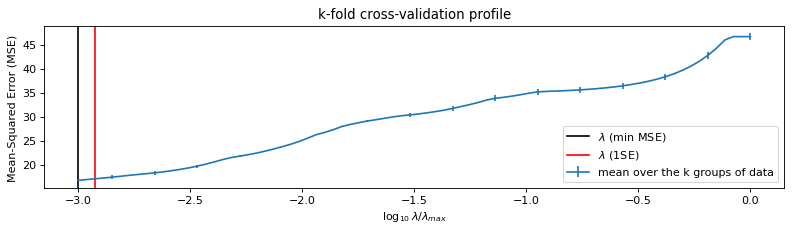

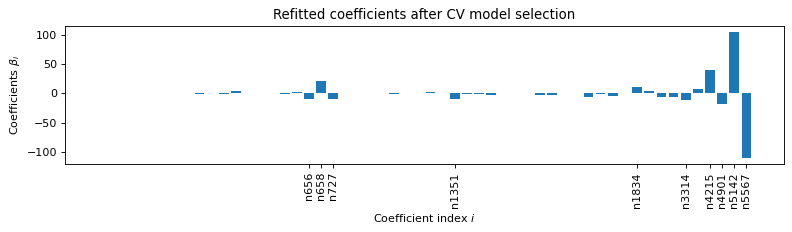


 CROSS VALIDATION : 
    Intercept : 8.163837992584526
   Selected variables :  s__uncultured_Dorea    s__Lactobacillus_mucosae    s__Lactobacillus_ruminis    g__Blautia    g__Dialister    g__Blautia    f__Enterobacteriaceae    g__Romboutsia    n6    n7    n89    n119    n157    n158    n163    n213    n635    n656    n658    n727    n805    n952    n1030    n1166    n1203    n1204    n1208    n1218    n1328    n1351    n1435    n1482    n1489    n1511    n1553    n1559    n1571    n1585    n1622    n1644    n1687    n1717    n1718    n1719    n1834    n2101    n2946    n2947    n3314    n4126    n4215    n4901    n5142    n5567    
   Running time :  477.723s



In [19]:
problem.solve()
# todo: find out how to extract the insights from the model to disk without changing classo
print(problem.solution)

In [20]:
# alpha [0] is learned intercept, alpha [1:] are learned coefficients for all features
# in logGeom (n_samples, n_features)
# ! if oneSE=True -> uses lambda_1SE else lambda_min (see CV in
# ! classo>cross_validation.py)
# refit -> solves unconstrained least squares problem with selected lambda and
# variables
alpha = problem.solution.CV.refit

In [21]:
# ! class solution_CV: defined in @solver.py L930
selection = problem.solution.CV.selected_param[1:]  # exclude the intercept
selected_ft = label[selection]
print(selected_ft)

['d__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Dorea; s__uncultured_Dorea'
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__Lactobacillus_mucosae'
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__Lactobacillus_ruminis'
 'd__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Blautia'
 'd__Bacteria; p__Firmicutes; c__Negativicutes; o__Veillonellales-Selenomonadales; f__Veillonellaceae; g__Dialister'
 'd__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Blautia'
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Enterobacteriaceae'
 'd__Bacteria; p__Firmicutes; c__Clostridia; o__Peptostreptococcales-Tissierellales; f__Peptostreptococcaceae; g__Romboutsia'
 'n6' 'n7' 'n89' 'n119' 'n157' 'n158' 'n163' 'n213' 'n635' 'n656' 'n658'
 'n727' 'n805' 'n952'

In [22]:
# # selected lambda with 1-standard-error method
# problem.solution.CV.lambda_1SE

# # selected lambda without 1-standard-error method
# problem.solution.CV.lambda_min

In [23]:
# save model: A, label, alpha (includes selected_ft)
# todo: adjust path
path2out = "test_model"
if not os.path.exists(path2out):
    os.makedirs(path2out)

# storing A w labels
df_A_with_labels = pd.DataFrame(A, columns=label, index=label[:nb_features])
df_A_with_labels.to_csv(os.path.join(path2out, "matrix_a_w_labels.csv"), index=True)

In [24]:
# storing alpha w labels
idx_alpha = ["intercept"] + label.tolist()
df_alpha_with_labels = pd.DataFrame(alpha, columns=["alpha"], index=idx_alpha)
df_alpha_with_labels.to_csv(
    os.path.join(path2out, "model_alpha_w_labels.csv"), index=True
)

# we can get selected features from alpha
selected_ft_inf = df_alpha_with_labels[
    df_alpha_with_labels["alpha"] != 0
].index.tolist()
assert selected_ft_inf[1:] == selected_ft.tolist()

## Perform prediction on test set

In [25]:
# derive log_geom for test
ft_cols = [x for x in test.columns if x.startswith("F")]

x_test = test[ft_cols]
y_test = test[target]
# todo: read A
log_geom_test, nleaves = _preprocess_taxonomy_aggregation(x_test.values, A)

# apply model to test
# todo: read alpha
y_test_pred = log_geom_test.dot(alpha[1:]) + alpha[0]